## Import the librairies for the processing

In [14]:
%run librairiesCNN.py

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


Fix random seed to make sure we get reproducible results.

In [15]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)

## Set parameters for the DNS test

In [16]:
#Specify the maximum discplacement, particle sizes and particle density per interrogation 
#window to be used for the synthetic image
#Choose the final size of the synthetic image, it will rescale the DNS by cropping or interpolating
width=1024
height=1024
maxDisplacement=24# in px
particleRadius=range(2,4) #for each particle
gaussianBlurRadius=1
particleDensity=range(2,10) #per image

############################ SAVING DATA ####################################################
#If you want to save the images, set recordImage=True and specify the location and name 
#of the saved files. Make sure the directory DATASETfromDNS exist 
saveImage=False
folder='data/'
imageFile='dataset_JN'

## Load convolutional networks and setup an ensemble 

In [17]:
from CNN_architectures import StreaksCNN

file_net = 'networks/network_grayscale_gradient_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = '%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()
    
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

CNN_width=windowSize
CNN_height=windowSize
overlap=24

## Load DNS

In [18]:
### IN PYTHON X,Y are lines,columns, the DNS must be transposed
fileName='./data/dataSetFromDNS_EPM.hdf5'
f=h5py.File(fileName,'r')

# store data in array
_x00=f[('x')][:]
_y00=f[('y')][:]
u00=f[('u')][:]
v00=f[('v')][:]
# rescaling DNS to the user defined max displacement
u00=u00/u00.max()*maxDisplacement
v00=v00/v00.max()*maxDisplacement

f.close()

originalDisplacement=np.sqrt(u00**2+v00**2)

print('Upload data from {}'.format(fileName))
print('Original Shape of X {}'.format(_x00.shape[0]))
print('Original Shape of Y {}'.format(_y00.shape[0]))
print('Original Shape of U,V {}'.format(u00.shape))

#if the desired image size is different from the original data set, we crop or interpolate
if (_x00.shape[0]!=width) or (_y00.shape[0]!=height):
    resizeImage=True
    _x=np.arange(width)
    _y=np.arange(height)
    u=np.array(skimage.transform.resize(u00, (height, width), anti_aliasing=True))
    v=np.array(skimage.transform.resize(v00, (height, width), anti_aliasing=True))
else:
    resizeImage=False
    _x=_x00
    _y=_y00
    u,v=u00,v00

Upload data from ./data/dataSetFromDNS_EPM.hdf5
Original Shape of X 192
Original Shape of Y 192
Original Shape of U,V (192, 192)


## Calculate the mean displacement, angle and energy spectrum

In [19]:
x,y=np.meshgrid(_x,_y)
displacement=np.sqrt(u**2+v**2)
angle=np.arctan(v/u)*180/np.pi
energy=np.mean(displacement)**2
kx,Ekx,ky,Eky,k,Ek,Ek2D = getEnergySpectrum(_x,_y,displacement-displacement.mean())

originalWidth=_x00.shape[0]
originalheight=_y00.shape[0]
resizedWidth=_x.shape[0]
resizedHeight=_y.shape[0]

print('resizing image')
print('Resized X {}'.format(resizedWidth))
print('Resized Y {}'.format(resizedHeight))
print('Resized U,V {}'.format(u.shape))

xdns,ydns,displacementdns,angledns,W,H=windowAveraging(displacement,angle,CNN_width,CNN_height,overlap)

resizing image
Resized X 1024
Resized Y 1024
Resized U,V (1024, 1024)


Plot DNS and its statistics

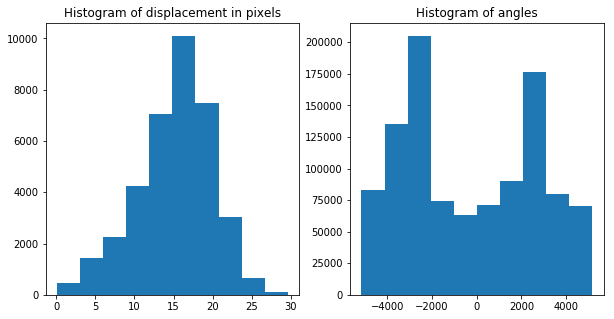

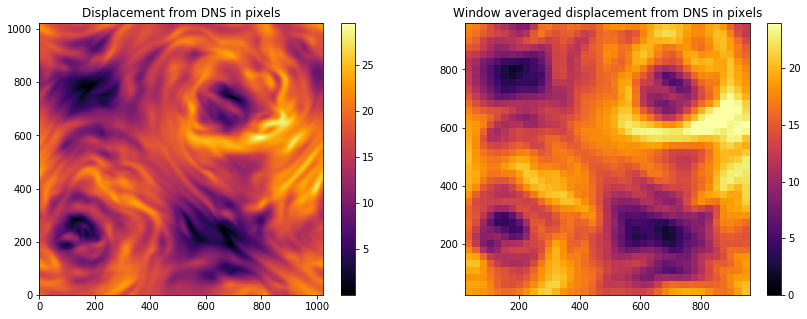

In [20]:
fig = figure(figsize=(10,5))
fig.add_subplot(1,2,1)
title('Histogram of displacement in pixels')
hist(originalDisplacement.flatten())   
fig.add_subplot(1,2,2)
title('Histogram of angles')
hist(angle.flatten()*180/np.pi)
show()

fig = figure(figsize=(14,5))
fig.add_subplot(1,2,1)
title('Displacement from DNS in pixels')
p = pcolormesh(x,y,displacement,cmap='inferno')
colorbar(p)
fig.add_subplot(1,2,2)
title('Window averaged displacement from DNS in pixels')
pmean = pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pmean)
show()

## Generate streak images from DNS

Finished, took 46.7543s. 2.14 images/sec.


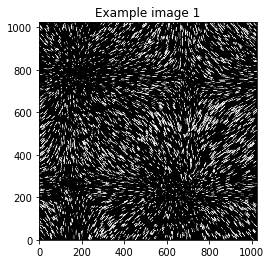

In [21]:
# Generate count images
nImages = 100
start_time = time.time()
myImagesGenerator = DNS_StreakImageGenerator(x,y,u,v,particleDensity,particleRadius,CNN_width,CNN_height)
myImages= myImagesGenerator.generate(count = nImages, sigma = 1, truncate = 2)
elapsed_time = time.time() - start_time
print("Finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
        nImages / elapsed_time))
     
# Plot one of images
iImage = 1
figure()
title('Example image %d' % iImage)
gray()
imshow(myImages[iImage,0,:,:], origin='lower')

im = Image.fromarray(myImages[iImage,0,:,:])

# Save images in an HDF5 file
if saveImage:
    fileName = folder + imageFile + '.hdf5'
    h = h5py.File(fileName,'w')
    h.create_dataset('x',data=x)
    h.create_dataset('y',data=y)
    h.create_dataset('u',data=u)
    h.create_dataset('v',data=v)
    h.create_dataset('images',data=myImages)
    h.close()
    
imsave('dnsImage.png', myImages[1,0,:,:])

## Apply the CNN ensemble to the batch of synthetic images

In [26]:
# Apply the N networks to the image , 
applyEnsemble = True 
# Otherwise apply the n-th network only
cnnIndex = 3 

_xcnnConcatenated,_ycnnConcatenated,splittedImages,nh,nw =\
splitWindows(myImages,CNN_width,CNN_height,overlap)

start_time=time.time()

predictionEnsemble=np.zeros((n_ensemble_members,splittedImages.shape[1],2))
predictionSingle=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
prediction=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
displacementcnn=np.zeros((splittedImages.shape[0],nh,nw))
anglecnn=np.zeros((splittedImages.shape[0],nh,nw))

print('Processing with Ensemble image:', end=' ')
for iImage in range(nImages):  
    imagesTOprocess = splittedImages[iImage,:,:,:,:]
    inputs = torch.from_numpy(np.array(imagesTOprocess) / 255).type(torch.FloatTensor)
    inputs = inputs.to(device)
    
    if applyEnsemble:
        print(iImage, end=', ')
        for n in range(n_ensemble_members):
            net = net_ensemble[n]
            net.eval()
            net_outputs = net(inputs) 
            if 'cuda' in device.type:
                net_outputs = net_outputs.cpu()

            predictionEnsemble[n,:,:] = scaler.inverse_transform(net_outputs.data.numpy())
            prediction[iImage,:,:] += predictionEnsemble[n,:,:]

        prediction /= n_ensemble_members
    
    else:    
        print(iImage, end=', ')
        net = net_ensemble[cnnIndex]
        net.eval()
        # Forward pass
        net_outputs = net(inputs)
        if 'cuda' in device.type:
            net_outputs = net_outputs.cpu()

        prediction[iImage,:,:] = scaler.inverse_transform(net_outputs.data.numpy())

    displacementcnn[iImage,:,:] = np.reshape(prediction[iImage,:,0], (nh,nw))
    anglecnn[iImage,:,:] = np.reshape(prediction[iImage,:,1], (nh,nw))
    xcnn = np.reshape(np.array(_xcnnConcatenated), (nh,nw))
    ycnn = np.reshape(np.array(_ycnnConcatenated), (nh,nw))
    _xcnn = xcnn[:,0]
    _ycnn = ycnn[0,:]

elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            nImages / elapsed_time))

Processing with Ensemble image: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Testing finished, took 15.3509s. 6.51 images/sec.


## Quantify error of the ensemble prediction against the ground truth

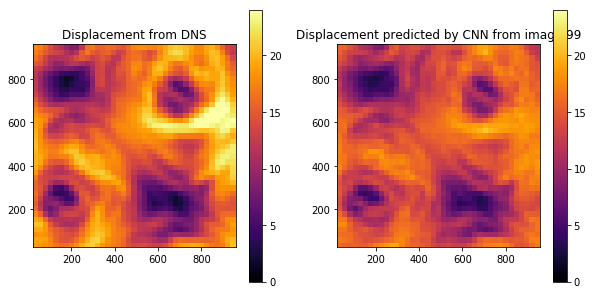

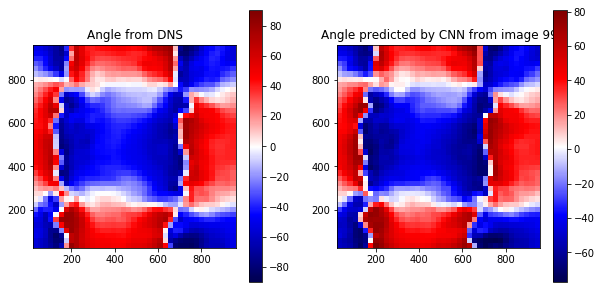

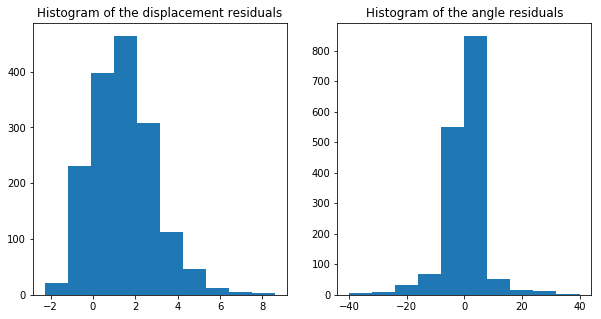

In [32]:
meanDisplacementCNN = np.mean(displacementcnn, axis=0)
meanAngleCNN = np.mean(anglecnn, axis=0)

errorDisplacement=[]
errorAngle=[]
errorSpectrum=[]

errorDisplacement.append(displacementdns - meanDisplacementCNN)
errorAngle.append(angledns - meanAngleCNN)

figure(figsize=(10,5))
subplot(1,2,1)
title('Displacement from DNS')
pdispdns=pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispdns)
axis('scaled')
subplot(1,2,2)

title('Displacement predicted by CNN from image %d' % iImage)
pdispcnn=pcolormesh(xdns,ydns,meanDisplacementCNN,vmin=0,vmax=maxDisplacement,cmap='inferno')
axis('scaled')
colorbar(pdispcnn)
show()

figure(figsize=(10,5))
subplot(1,2,1)
title('Angle from DNS')
pangdns=pcolormesh(xdns,ydns,angledns,vmin=-90,vmax=90, cmap='seismic')
colorbar(pangdns)
axis('scaled')

subplot(1,2,2)
title('Angle predicted by CNN from image %d' % iImage)
panglecnn=pcolormesh(xdns,ydns,meanAngleCNN, cmap='seismic')
colorbar(panglecnn)
axis('scaled')
show()

figure(figsize=(10,5))
subplot(1,2,1)
title('Histogram of the displacement residuals')
h1=hist(np.array(errorDisplacement).flatten(), density=False)

subplot(1,2,2)
title('Histogram of the angle residuals')
h2=hist(np.array(errorAngle).flatten(), range=(-40,40),density=False)

## Compare the DNS-raw streaks image with CNN recovered streaks

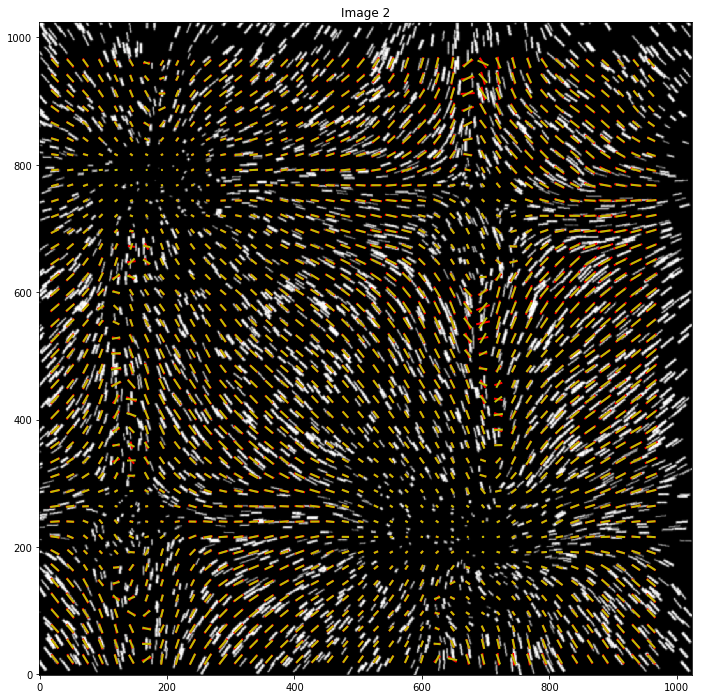

In [24]:
#select an image to compare the results to 
iImage=2

plotdns=True
plotcnn=True
showimage=True

fig=figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
ax.set_title('Image %d' % iImage)
if showimage==True:
    imshow((myImages[iImage,0,:,:]), origin='lower')

#Streas from DNS
if plotdns==True:
    xminus = xdns.flatten() - np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    xplus = xdns.flatten() + np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    yminus = ydns.flatten() - np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    yplus = ydns.flatten() + np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    xydns = np.array(([xminus, yminus], [xplus, yplus]));

    for i in range(0,xydns.shape[2]):
        linedns = patches.Polygon(xydns[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(linedns)
    
#Streaks from CNN
if plotcnn==True:
    x0 = xcnn.flatten() - np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    x1 = xcnn.flatten() + np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    y0 = ycnn.flatten() - np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    y1 = ycnn.flatten() + np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    xycnn = np.array(([x0, y0], [x1, y1]));

    for i in range(0,xycnn.shape[2]):
        line = patches.Polygon(xycnn[:,:,i], color = 'y', linewidth = 2)
        ax.add_patch(line)

show()